In [0]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, log_loss, precision_recall_curve, auc, average_precision_score
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import pandas as pd
import numpy as np

/databricks/python/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [0]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def transform_df(train_set_path,test_set_path):
    train = pd.read_csv(train_set_path,index_col =0)
    test = pd.read_csv(test_set_path,index_col =0)


    # separate features and labels
    X_train_raw = train.drop(['msno','is_churn'], axis=1)
    y_train = train['is_churn']

    # separate features and labels
    X_test_raw = test.drop(['msno','is_churn'], axis=1)
    y_test = test['is_churn']

    # replace missing values
    impute = ColumnTransformer(
    transformers=[('missing values', SimpleImputer(strategy='most_frequent'), ['last_payment_method', 'city', 'gender', 'registered_via', 'bd'])],
    remainder='passthrough'
    )

    # encode categoricals and scale all others
    encode_scale =  ColumnTransformer( 
    transformers= [('ohe categoricals', OneHotEncoder(categories='auto', drop='first'), slice(0,4))], # features 0 through 3 should be the first four features imputed in previous step
    remainder= StandardScaler()  # standardize all other features
    )

    # package transformation logic
    transform = Pipeline([
    ('impute', impute),
    ('encode_scale', encode_scale)
    ])

    # apply transformations
    X_train = transform.fit_transform(X_train_raw)
    X_test = transform.transform(X_test_raw)
    print("X_train shape: ",X_train.shape)
    print("------------------------------------------")
    print("X_test shape: ",X_test.shape)

    return train,test,X_train,y_train,y_test,X_test

train_path = "/dbfs/FileStore/Customer_Churn_Datasets/Datasets/train.csv"
test_path = "/dbfs/FileStore/Customer_Churn_Datasets/Datasets/test.csv"
train,test,X_train,y_train,y_test,X_test=transform_df(train_path,test_path)

/databricks/python/lib/python3.10/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


X_train shape:  (856143, 102)
------------------------------------------
X_test shape:  (853903, 102)


In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(856143, 102)
(853903, 102)
(856143,)
(853903,)


In [0]:
weights = compute_class_weight(
  'balanced', 
  classes=np.unique(y_train), 
  y=y_train
  )
weights

array([ 0.51722069, 15.017418  ])

In [0]:
import mlflow
import mlflow.tensorflow
import mlflow.keras
import mlflow.sklearn
import tensorflow as tf
from tensorflow import keras

# Set the MLflow tracking URI to point to your MLflow server
# mlflow.set_tracking_uri("databricks")

# Configure the MLflow experiment
# mlflow.set_experiment("/databricks/experiment/path")

# Enable autologging for TensorFlow and Keras
mlflow.tensorflow.autolog()
    # Create a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(102,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Start a new MLflow run

with mlflow.start_run():
    # Train the model and store the training history
    model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

    # Log the model
    mlflow.tensorflow.log_model(model, "model")

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Log the test metrics
    mlflow.log_metrics({'test_loss': test_loss, 'test_accuracy': test_accuracy})
    run_id = mlflow.active_run().info.run_id



2023/07/19 10:22:08 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/2
 4820/26755 [====>.........................] - ETA: 31s - loss: 0.1089 - accuracy: 0.9676

*** WARNING: max output size exceeded, skipping output. ***

1/1 [==============================] - 0s 63ms/step
INFO:tensorflow:Assets written to: /tmp/tmpk6a95csi/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpk6a95csi/model/data/model/assets
2023/07/19 10:24:25 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.5.0/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.
2023/07/19 10:24:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpmjx4a2tl/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpmjx4a2tl/model/data/model/assets


 7056/26685 [======>.......................] - ETA: 19s - loss: 0.1149 - accuracy: 0.9632

*** WARNING: max output size exceeded, skipping output. ***

26685/26685 [==============================] - 26s 965us/step - loss: 0.1135 - accuracy: 0.9634


In [0]:
print (run_id)

d957db72f4af4dcbad602bd14d5d7ecb


In [0]:
run_id='d957db72f4af4dcbad602bd14d5d7ecb'

In [0]:
model_name = "Neural_Network_model"


In [0]:
import mlflow
# The default path where the MLflow autologging function stores the model
artifact_path = "model"
model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id, artifact_path=artifact_path)
model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

Registered model 'Neural_Network_model' already exists. Creating a new version of this model...
2023/07/19 13:11:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Neural_Network_model, version 5
Created version '5' of model 'Neural_Network_model'.


In [0]:
# After creating a model version, it may take a short period of time to become ready. Certain operations, such as model stage transitions, require the model to be in the READY state.
# import time
# from mlflow.tracking.client import MlflowClient
# from mlflow.entities.model_registry.model_version_status import ModelVersionStatus
# def wait_until_ready(model_name, model_version):
#   client = MlflowClient()
#   for _ in range(10):
#     model_version_details = client.get_model_version(
#       name=model_name,
#       version=model_version,
#     )
#     status = ModelVersionStatus.from_string(model_version_details.status)
#     print("Model status: %s" % ModelVersionStatus.to_string(status))
#     if status == ModelVersionStatus.READY:
#       break
#     time.sleep(1)
  
# wait_until_ready(model_details.name, model_details.version)

Model status: READY


In [0]:
print(model_details.name,model_details.version)

Neural_Network_model 3


In [0]:
# Add a high-level description to the registered model, including the machine learning problem and dataset.
from mlflow.tracking.client import MlflowClient

client = MlflowClient()
client.update_registered_model(
  name=model_details.name,
  description="This is a neural network to check churn user."
)

<RegisteredModel: aliases={}, creation_timestamp=1689670450755, description='This is a neural network to check churn user.', last_updated_timestamp=1689772291282, latest_versions=[], name='Neural_Network_model', tags={}>

In [0]:
# client.update_model_version(
#   name=model_details.name,
#   version=model_details.version,
#   description="This model version was built using TensorFlow Keras. It is a feed-forward neural network with one hidden layer."
# )

Out[14]: <ModelVersion: creation_timestamp=1689670451108, current_stage='None', description=('This model version was built using TensorFlow Keras. It is a feed-forward '
 'neural network with one hidden layer.'), last_updated_timestamp=1689671534795, name='Neural_Network_model', run_id='314ea6a4b4d44eff993ea29a04fc4408', run_link='', source='dbfs:/databricks/mlflow-tracking/618288948357404/314ea6a4b4d44eff993ea29a04fc4408/artifacts/model', status='READY', status_message='', tags={}, user_id='5184971542956623', version='1'>

In [0]:
# Perform a model stage transition
client.transition_model_version_stage(
  name=model_details.name,
  version=model_details.version,
  stage='Production',
)

<ModelVersion: aliases=[], creation_timestamp=1689772284972, current_stage='Production', description='', last_updated_timestamp=1689772293836, name='Neural_Network_model', run_id='d957db72f4af4dcbad602bd14d5d7ecb', run_link='', source='dbfs:/databricks/mlflow-tracking/618288948357404/d957db72f4af4dcbad602bd14d5d7ecb/artifacts/model', status='READY', status_message='', tags={}, user_id='5184971542956623', version='5'>

In [0]:
# # Use the MlflowClient.get_model_version() function to fetch the model's current stage.
# model_version_details = client.get_model_version(
#   name=model_details.name,
#   version=model_details.version,
# )
# print("The current model stage is: '{stage}'".format(stage=model_version_details.current_stage))

The current model stage is: 'Production'


In [0]:
# latest_version_info = client.get_latest_versions(model_name, stages=["Production"])
# latest_production_version = latest_version_info[0].version
# print("The latest production version of the model '%s' is '%s'." % (model_name, latest_production_version))

The latest production version of the model 'Neural_Network_model' is '1'.


In [0]:
# import mlflow.pyfunc

# model_version_uri = "models:/{model_name}/1".format(model_name=model_name)

# print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_version_uri))
# model_version_1 = mlflow.pyfunc.load_model(model_version_uri)

Loading registered model version from URI: 'models:/Neural_Network_model/1'


/databricks/python/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [0]:
# model_production_uri = "models:/{model_name}/production".format(model_name=model_name)

# print("Loading registered model version from URI: '{model_uri}'".format(model_uri=model_production_uri))
# model_production = mlflow.pyfunc.load_model(model_production_uri)

Loading registered model version from URI: 'models:/Neural_Network_model/production'


/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [0]:
  
def test_power(model_name, model_stage):
  from mlflow.tracking.client import MlflowClient
  client = MlflowClient()
  model_version = client.get_latest_versions(model_name, stages=[model_stage])[0].version
  model_uri = "models:/{model_name}/{model_stage}".format(model_name=model_name, model_stage=model_stage)
  model = mlflow.pyfunc.load_model(model_uri)

  power_predictions = pd.DataFrame(model.predict(X_test))
  return(power_predictions)



In [0]:
prediction=test_power("Neural_Network_model", "Production")
print(prediction)

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


26685/26685 [==============================] - 23s 844us/step
[[0.00512958]
 [0.01882527]
 [0.00476733]
 ...
 [0.02976881]
 [0.00455394]
 [0.00105635]]


In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_predicted = test_power(model_name, "Production") > 0.5
# y_predicted=pd.DataFrame([int(round(x[0])) for x in prediction])
mat = confusion_matrix(y_test, y_predicted)
labels = ['Not churn', 'Churn']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-1362083491506704>:6
      4 # y_predicted = test_power(model_name, "Production") > 0.5
      5 y_predicted=pd.DataFrame([int(round(x[0])) for x in prediction])
----> 6 mat = confusion_matrix(y_test, y_predicted)
      7 labels = ['Not churn', 'Churn']
      9 sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
     10             xticklabels=labels, yticklabels=labels)

File /local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/mlflow/utils/autologging_utils/safety.py:552, in safe_patch.<locals>.safe_patch_function(*args, **kwargs)
    550     patch_function.call(call_original, *args, **kwargs)
    551 else:
--> 552     patch_function(call_original, *args, **kwargs)
    554 session.state = "succeeded"
    556 try_log_autologging_event(
    557     AutologgingEventLogger.

In [0]:
mlflow.sklearn.autolog()
# Configure the MLflow experiment
mlflow.set_experiment("/Users/dipika.dhara@kasmo.co/churn")
with mlflow.start_run():

    n_estimators = 1000
    max_depth = 6
    max_features = 3
    # train the model
    rfc_model = RandomForestClassifier(class_weight='balanced',n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
    rfc_model.fit(X_train, y_train)

    # predict
    rfc_y_prob = rfc_model.predict_proba(X_test)

    # evaluate
    rfc_ap = average_precision_score(y_test, rfc_y_prob[:,1])
    run_id_rf= mlflow.active_run().info.run_id



2023/07/19 11:51:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


In [0]:
print(run_id_rf)

a396d3f3fc394a18b952d35156b3df59


In [0]:
run_id_rf='a396d3f3fc394a18b952d35156b3df59'

In [0]:
model_name = "Random_Forest_Model"

In [0]:
import mlflow
# The default path where the MLflow autologging function stores the model
artifact_path = "model"
model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id_rf, artifact_path=artifact_path)
model_details = mlflow.register_model(model_uri=model_uri, name=model_name)

Registered model 'Random_Forest_Model' already exists. Creating a new version of this model...
2023/07/19 13:17:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Random_Forest_Model, version 3
Created version '3' of model 'Random_Forest_Model'.


In [0]:
from mlflow.tracking.client import MlflowClient
client = MlflowClient()
client.update_registered_model(
  name=model_details.name,
  description="This is a Random_Forest_Model to check churn user."
)

<RegisteredModel: aliases={}, creation_timestamp=1689769890880, description='This is a Random_Forest_Model to check churn user.', last_updated_timestamp=1689772682310, latest_versions=[], name='Random_Forest_Model', tags={}>

In [0]:
# Perform a model stage transition
client.transition_model_version_stage(
  name=model_details.name,
  version=model_details.version,
  stage='Production',
)

<ModelVersion: aliases=[], creation_timestamp=1689772676040, current_stage='Production', description='', last_updated_timestamp=1689772682411, name='Random_Forest_Model', run_id='a396d3f3fc394a18b952d35156b3df59', run_link='', source='dbfs:/databricks/mlflow-tracking/4084284757752761/a396d3f3fc394a18b952d35156b3df59/artifacts/model', status='READY', status_message='', tags={}, user_id='5184971542956623', version='3'>

In [0]:
def test_power(model_name, model_stage):
  from mlflow.tracking.client import MlflowClient
  client = MlflowClient()
  model_version = client.get_latest_versions(model_name, stages=[model_stage])[0].version
  model_uri = "models:/{model_name}/{model_stage}".format(model_name=model_name, model_stage=model_stage)
  model = mlflow.pyfunc.load_model(model_uri)

  power_predictions = pd.DataFrame(model.predict(X_test))
  return(power_predictions)

In [0]:
prediction=test_power(model_name, "Production")
print(prediction)

        0
0       0
1       0
2       0
3       0
4       0
...    ..
853898  0
853899  0
853900  0
853901  0
853902  0

[853903 rows x 1 columns]


Text(113.9222222222222, 0.5, 'Actual label')

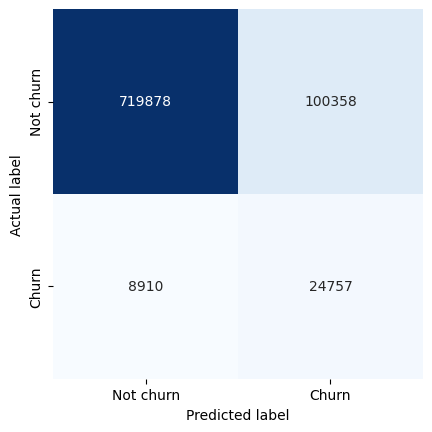

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_predicted = test_power(model_name, "Production")
mat = confusion_matrix(y_test, y_predicted)
labels = ['Not churn', 'Churn']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')